<center><a href="https://www.nvidia.cn/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 4b. VSS 第二部分：问答和 Graph-RAG 

在上一个实验中，我们学习了如何使用 NVIDIA 的[视频搜索和摘要 AI 智能体](https://build.nvidia.com/nvidia/video-search-and-summarization/blueprintcard)来进行视频摘要。本实验将探索用户如何向这个 AI 智能体提问视频内容相关的问题。

#### 学习目标:
本文档的目标是：
- 通过 VSS REST API 探索视频的问答
- 了解 Graph-RAG（图形-RAG）组件
- 在 Neo4J 中可视化知识图谱
- 使用 Vector-RAG 进行问答（无 Graph-RAG）

## 使用 VSS 执行问答（Q&A）任务

VSS 通过 **Vector-RAG** 和 **Graph-RAG** 支持问答（Q&A）功能。 Vector-RAG 是实时流处理的唯一支持方法，而 Graph-RAG 专门用于基于视频的查询。

**使用 Vector-RAG 执行问答任务：** VLM 生成的标题及其嵌入保存在 Milvus 数据库中。给定查询时，检索出最相关的前五个块，使用 ```llama-3.2-nv-rerankqa-1b-v2``` 重新排序，然后传给 LLM 生成最终答案。

**使用 Graph-RAG  执行问答任务：** 为了捕获 VLM 生成的复杂信息，在处理视频过程中构建并存储知识图谱。使用 LLM 将密集的标题转换为一组节点、边及相关属性。该知识图谱存储在图数据库中。使用 ```llama-3.2-nv-embedqa-1b-v2``` 生成的标题和嵌入也与这些实体相关联。通过使用 Graph-RAG  技术，LLM 可以访问此信息以提取问答的关键信息。

![VSS CA-RAG 图示](images/VSS_CA-RAG.png)

## 4.1 设置环境

我们使用与上一个实验相同的 VSS 服务器。确认一下它已正常运行。

In [1]:
warehouse_video = "data/warehouse.mp4"

In [2]:
host = "via-server" #e.g., 0.0.0.0 or localhost
port = "8000" #e.g., 8000

In [3]:
import requests
import yaml

vss_url = f"http://{host}:{port}"

ready_check_url = f"{vss_url}/health/ready"
response = requests.get(ready_check_url)

if response.status_code == 200:
    print(f"Service is ready.")
else:
    print(f"Service is not ready. Status code: {response.status_code}")

Service is ready.


## 4.2 探索视频问答

请参考之前的实验，以探索所有 REST API 端点。下面用 REST API 上传文件，开启视频处理并启用聊天，然后提几个问题试试。

<!-- ![仓库场景](images/warehouse.png) -->

<video width="1000 " height=" " 
       src="data/warehouse.mp4"  
       controls>
</video>

### 4.2.1 上传视频文件

让我们先上传一个视频，并从响应中保存文件 ID。

In [4]:
upload_url = f"{vss_url}/files"
files = {'file': ('filename_with_extension', open(warehouse_video, 'rb'))}

response = requests.post(upload_url, data={'purpose': 'vision', 'media_type': 'video'}, files=files)

if response.status_code == 200:
    video_id=response.json().get('id')
    print("Video Uploaded")
    print(f"Video file ID: {video_id}")
else:
    print(f"Failed to upload file. Status code: {response.status_code}")

Video Uploaded
Video file ID: fe86e52c-dc21-4806-a4a9-643449a477a6


### 4.2.2 视频摄取（Ingestion）和处理

接下来，我们处理视频以生成密集描述和知识图谱。这个步骤可能需要几分钟。
- 首先，设置提示词
- 然后，调用总结 API 来摄取视频
- 请注意，这里将 ```enable_chat``` 设置为 True，以创建知识图谱

In [5]:
prompts = {
    "vlm_prompt": "You are a warehouse monitoring system. Describe the events in this warehouse and look for any anomalies. "
                            "Start each sentence with start and end timestamp of the event.",
    
    "caption_summarization": "You will be given captions from sequential clips of a video. Aggregate captions in the format "
                             "start_time:end_time:caption based on whether captions are related to one another or create a continuous scene.",
    
    "summary_aggregation": "Based on the available information, generate a summary that captures the important events in the video. "
                           "The summary should be organized chronologically and in logical sections. This should be a concise, "
                           "yet descriptive summary of all the important events. The format should be intuitive and easy for a "
                           "user to read and understand what happened. Format the output in Markdown so it can be displayed nicely."
}

In [6]:
def process_video(prompts, video_id=video_id):
    
    process_video_url = f"{vss_url}/summarize"

    payload = {
        "id": video_id,
        "prompt": prompts['vlm_prompt'],
        "caption_summarization_prompt": prompts['caption_summarization'],
        "summary_aggregation_prompt": prompts['summary_aggregation'],
        "model": "vila-1.5",
        "chunk_duration": 10,
        "chunk_overlap_duration": 0,
        "summarize": False,
        "enable_chat": True,
    }

    try:
        response = requests.post(process_video_url, json=payload)
        
        if response.status_code == 200:
            response_data = response.json()
            # Extracting the summary content
            summary = response_data.get('choices', [])[0].get('message', {}).get('content', '')
            return summary if summary else "No content received."
        else:
            return f"Failed to summarize. Status code: {response.status_code}. Response: {response.text}"
    
    except requests.RequestException as e:
        return f"An error occurred: {e}"

In [7]:
process_video(prompts)

'Media processed'

### 4.2.3 提问

一旦视频处理完成，就可以调用 ```/chat/completions``` 端点来提问

![问答端点](images/qna_swagger.png)

In [8]:
def qna(query, video_id=video_id):

    qna_url = f"{vss_url}/chat/completions"

    payload = {
        "id": video_id,
        "messages": [
            {
                "content": query,
                "role": "user",
            }
        ],
        "model": "vila-1.5"
    }

    try:
        response = requests.post(qna_url, json=payload)
        
        if response.status_code == 200:
            response_data = response.json()
            # Extracting the answer content
            answer = response_data.get("choices", [])[0].get("message", {}).get("content", "")
            return answer if answer else "No answer received."
        else:
            return f"Failed to get a response. Status code: {response.status_code}. Response: {response.text}"
    
    except requests.RequestException as e:
        return f"An error occurred: {e}"

In [9]:
qna("Was there any forklift in the scene?")

'Yes, there was a forklift in the scene. A forklift driver was seen driving the forklift down the aisle of the warehouse, passing by the shelving units, and then turning around.'

In [10]:
qna("Was the worker carrying the box wearing PPE?")

'Yes, the worker carrying the box was wearing personal protective equipment (PPE), including a high-visibility vest and a yellow hard hat.'

## 4.3 理解 Graph-RAG  组件

![GraphRAG 图示](images/GraphRAG.png)

---

## 4.3.1 G-提取/索引（G-Extraction/Indexing）

### 密集标题到图的转换:
图提取器使用 LLM 来分析密集标题或任何文本输入，识别文本中的关键实体、动作和关系。

#### 示例:
给定一个关于仓库视频场景的标题，如：  
*“一个工人在传送带上放置了一个重箱子，由于放置不当，箱子掉了。”*  

- LLM 可以提取的实体包括：
  - **工人**（人）
  - **箱子**（物体）
  - **传送带**（设备）

- 识别出的关系可能包括：
  - **“工人在传送带上放置箱子”**
  - **“箱子因放置不当而掉落”**

这些实体和关系在 Neo4j 图中表示为节点和边。用 `nvidia/nv-embedqa-e5-v5` 生成的标题和嵌入也与这些实体相关联。这些能为用户查询提供描述性的答案。


---

## 4.3.2 G-检索器（G-Retriever）

### Cypher 查询生成:
图检索器利用 LLM 处理用户查询，并将其翻译为适合基于图搜索的结构化 cypher 查询。

#### 示例:
如果用户的查询是：  
*“是什么导致箱子掉落的？”*  

- LLM 确定关键实体（例如：“箱子”）和所需信息（例如：掉落的原因）。  
- 然后生成一个结构化的 cypher 查询，以供图使用：

```cypher
MATCH (b:Object)-[:PLACED_ON]->(c:Equipment), (b)-[:FALLS_DUE_TO]->(r:Reason)
WHERE b.name = 'Box'
RETURN r
```

在知识图谱上执行这个查询，可以检索相关信息，让用户能查询图中的复杂关系。


---

## 4.3.3 G-生成（G-Generation）

一旦图检索器处理用户查询并从知识图谱中获取相关子图（Sub-graph），比如实体、关系和标题，**G-生成**利用 LLM 分析并综合检索到的数据，生成一个连贯且有意义的响应。

### 示例:
如果用户的查询是：  
*"是什么导致箱子掉落的？"*  

图检索器可能会获取包含的子图：
- **节点**: 
  - 对象 (**箱子**)
  - 设备 (**传送带**)
  - 原因 (**放置不当**)
- **关系**:
  - **“箱子放置在传送带上”**
  - **“箱子因放置不当而掉落”**
- **标题**:
  - **“一名工人在传送带上放置了一个重箱子，箱子因放置不当而掉落。”**

G-生成会处理这些数据，将图结构及其属性结合起来，生成一个类似于：  
*"箱子掉落是因为它放置不当在传送带上。"*

---

### 我们再试几个问题

In [11]:
qna("What could be some possible safety issues in this warehouse?")

'Based on the video summary, some possible safety issues in this warehouse could be related to the use of forklifts, as a forklift driver is mentioned. Additionally, the presence of yellow caution tape, orange cones, and a person holding a measuring tape suggests that there may be some construction or maintenance work going on, which could pose tripping hazards or other safety risks. The warehouse also has tall shelving units, which could be a fall hazard if not properly secured or if items are not stored correctly.'

In [12]:
qna("When did the worker place the caution tape?")

'The video summary does not provide a specific time when the worker placed the caution tape. It only shows the worker pulling the yellow caution tape across the aisle of the warehouse, but it does not mention when the tape was initially placed.'

In [13]:
qna("Describe the warehouse setting in detail.")

'The warehouse is well-lit and organized, with aisles labeled alphabetically. The floor is made of concrete. There are high shelving units on both sides of the aisles, which are filled with boxes and other items. The shelves are neatly stacked with boxes and are labeled with letters. Orange traffic cones and yellow caution tape are present in the warehouse, blocking off certain areas.'

In [14]:
# qna("Enter your question")

In [15]:
# qna("Enter your question")

# 4.4  Graph-RAG  可视化

这部分将探索并可视化存储在 Neo4j 数据库中的知识图谱。通过 Neo4j Python 库，我们将可以通过查询来获取图的一部分，并可视化以更好地理解。这种可视化有助于检查图中的结构和关系，提供数据库中存储数据的清晰表示。

接下来的单元将生成指向 Neo4J 仪表板（dashboard）的链接。首先，将本 notebook 的网址（截止到 `.com`）复制到 `my_url` 中。

点击生成的链接后，输入 VSS 启动配置中设置的用户名和密码。
- 例如：
  - 用户名: neo4j
  - 密码: password

In [16]:
from IPython.display import display, HTML

my_url = "COPY_NOTEBOOK_URL"
my_url = my_url.rsplit(".com", 1)[0] + ".com"
neo4j_port = 64018

link_html = f'<a href="{my_url}:{neo4j_port}" target="_blank">点击这里打开 Neo4j 可视化仪表盘</a>'
display(HTML(link_html))

## 来自 Neo4j 可视化仪表盘的示例图

![Graph Diagram](images/graph_neo4j.png)

In [17]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt
import textwrap

def visualize_neo4j_query(query, host="graph-db", port=7687, user="neo4j", password="password"):
    try:
        graph = Graph(f"bolt://{host}:{port}", auth=(user, password))
    except Exception as e:
        print(f"Error connecting to Neo4j: {e}")
        return

    try:
        result = graph.run(query)
        G = nx.DiGraph()

        for record in result:
            path = record["p"]
            for rel in path.relationships:
                start_node = rel.start_node
                end_node = rel.end_node

                start_label = start_node.get("name", start_node.get("id", f"Node_{start_node.identity}"))
                end_label = end_node.get("name", end_node.get("id", f"Node_{end_node.identity}"))

                # Wrap labels for better readability if they are too long
                start_label = '\n'.join(textwrap.wrap(start_label, width=20))
                end_label = '\n'.join(textwrap.wrap(end_label, width=20))

                G.add_node(start_label)
                G.add_node(end_label)
                G.add_edge(start_label, end_label, label=rel.__class__.__name__)

        plt.figure(figsize=(15, 10))
        
        pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)
        
        nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=2500)
        nx.draw_networkx_labels(G, pos, font_size=8)
        edges = nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10)
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

        plt.title("Neo4j Graph Visualization")
        plt.show()

    except Exception as e:
        print(f"Error running query or visualizing the graph: {e}")


def get_neo4j_query_text(query, host="graph-db", port=7687, user="neo4j", password="password"):
    try:
        graph = Graph(f"bolt://{host}:{port}", auth=(user, password))
    except Exception as e:
        print(f"Error connecting to Neo4j: {e}")
        return

    try:
        result = graph.run(query)
        output = []

        for record in result:
            path = record["p"]
            for rel in path.relationships:
                start_node = rel.start_node
                end_node = rel.end_node

                start_label = start_node.get("name", start_node.get("id", f"Node_{start_node.identity}"))
                end_label = end_node.get("name", end_node.get("id", f"Node_{end_node.identity}"))

                output.append(f"Person: {start_label} placed an item: {end_label}")

        if not output:
            return "No results found."

        return "\n".join(output)

    except Exception as e:
        print(f"Error running query or processing the results: {e}")
        return None



## 部分 4.4.1 Cypher 查询

<span style="color:red"><b>注意: 您可能需要根据实际生成的图形修改以下 Cypher 查询中的实体和关系名称</b></span>

#### 可视化谁穿着什么

让我们看看与包含“WEARS”关键字的所有实体相关的子图:

以下 Cypher 查询检索并可视化与人们穿着物品的关系。它匹配图中的所有 `WEARS` 关系，并返回路径，以便更好地理解这些连接。

**Cypher 查询:**
```cypher
MATCH p=()-[r:WEARS]->() 
RETURN p
```

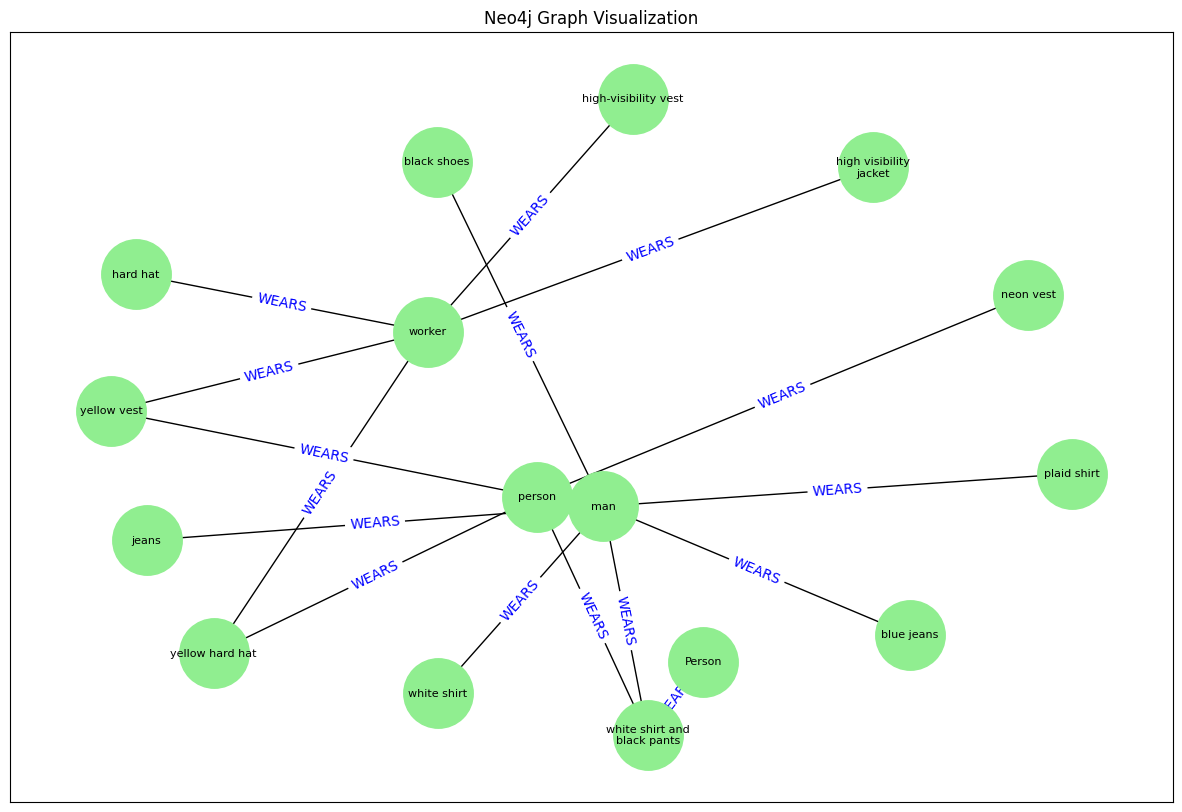

In [18]:
visualize_neo4j_query("MATCH p=()-[r:WEARS]->() RETURN p")

#### 可视化一个 id 为 "worker" 的携带物品的人的子图

下面的 Cypher 查询检索关于一个特定人（通过 `worker` 标识）携带物品的信息。它匹配人和物品之间的 `CARRIES` 关系，返回路径和动作的细节。

**Cypher 查询:**

```cypher
MATCH p=(person)-[r:CARRIES]->(item)
WHERE person.id = 'worker'
RETURN p
```


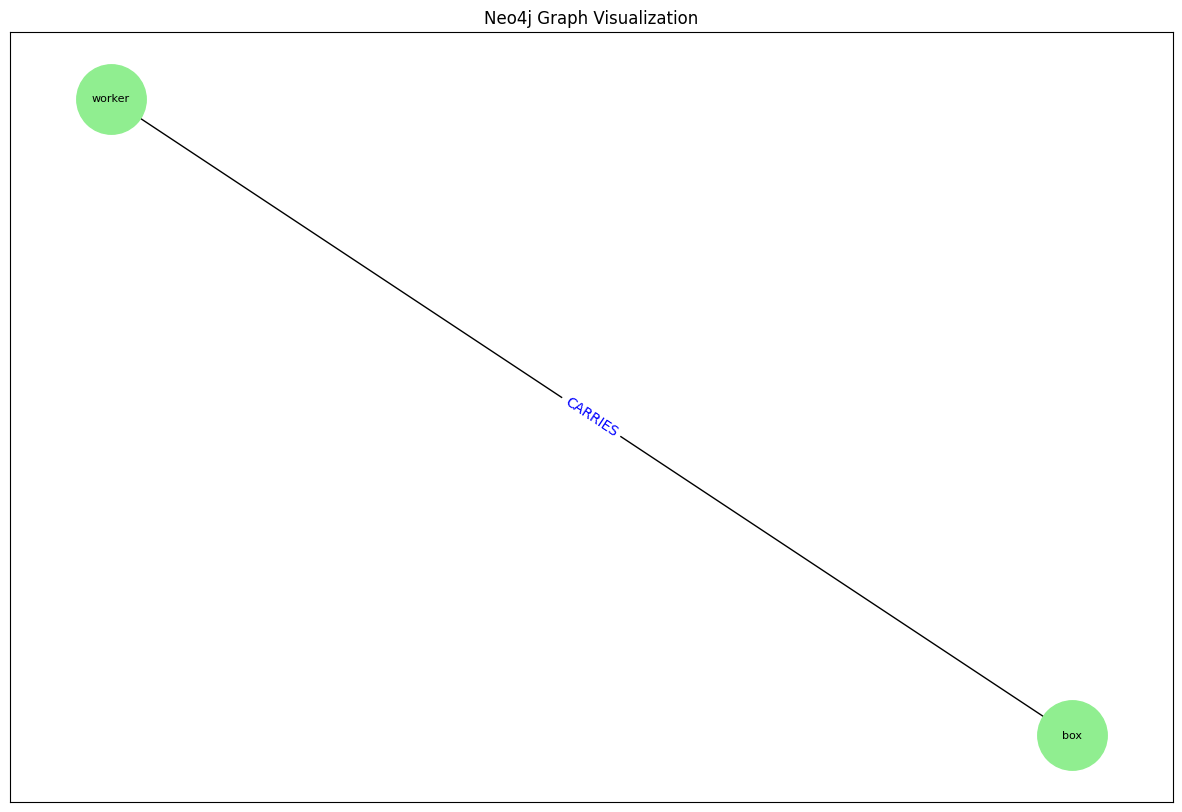

In [19]:
visualize_neo4j_query("MATCH p=(person)-[r:CARRIES]->(item) WHERE person.id = 'worker' RETURN p")

#### 使用 Cypher 查询获取特定节点

让我们看看我们的系统将如何回答“描述携带箱子的人。”我们之前问过这个问题。

下面的 Cypher 查询检索携带一个 `id` 为 "box" 物品的人的信息。它匹配一个人和物品之间的 `CARRIES` 关系，并返回放置者和他们放置的物品的细节。

**Cypher 查询:**

```cypher
MATCH p=(person)-[r:CARRIES]->(item)
WHERE item.id = "box"
RETURN p
```

In [20]:
query = """
MATCH p=(person)-[r:CARRIES]->(item)
WHERE item.id = "box"
RETURN p
"""

text_output = get_neo4j_query_text(query)
print(text_output)

Person: person placed an item: box
Person: worker placed an item: box
Person: man placed an item: box


## 接下来

恭喜您！到这里课程的全部内容就结束了，是时候在最后评估中检验您学到的知识了。祝您好运！